In [1]:
# from scipy.sparse import csr_matrix

## Входные данные

### Загрузка

In [2]:
# !unzip capstone_user_identification.zip

In [1]:
# from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import pickle
import numpy as np

In [2]:
PATH_TO_DATA = '../capstone_user_identification'
# PATH_TO_DATA = '../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2'

times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id', parse_dates=times)
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id', parse_dates=times)
df_train.shape, df_test.shape

((253561, 21), (82797, 20))

In [3]:
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

In [5]:
df_train['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Словарь сайтов

In [6]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    site2id  = pickle.load(f)
id2site = {v:k for (k, v) in site2id.items()}
id2site[0] = 'unknown'

In [7]:
df_train.sort_values(by='time1', inplace=True)

## Feature engineering

In [8]:
# from scipy.sparse import hstack
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

Рассмотрим признаки:
- Дата
    - час начала сессии
        - утро
        - день
        - вечер
        - ночь
        - циклические координаты (sin|cos часа)
    - месяц
        - сезон
    - год
        - год + месяц
    - день
        - выходной / будний
        - dummies
        - is_monday...
    - длина сессии
        - длина посещений каждого сайта
- Сайт
    - число уникальных сайтов в сессии (сколько повторов за сессию)
    - факт посещения абсолютно уникальных сайтов
    - факт посещения сайтов из топ-10 популярных сайтов
    - посещение определённых сайтов (facebook итд)

In [23]:
time_features_train = pd.DataFrame()
time_features_test = pd.DataFrame()
df_train_times = df_train[times]
df_test_times = df_test[times]

time_features_train['target'] = df_train["target"].astype('int')

In [25]:
def plot_feature(train, test, plot, x, y=None, bins='auto'):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    if plot == 'countplot':
        sns.countplot(train[x], ax=ax1)
        sns.countplot(test[x], ax=ax2)
        sns.countplot(train[train.target == 1][x], ax=ax3)
        sns.countplot(train[train.target == 0][x], ax=ax4)
    elif plot == 'histplot':
        sns.histplot(train[x], ax=ax1, bins=bins)
        sns.histplot(test[x], ax=ax2, bins=bins)
        sns.histplot(train[train.target == 1][x], ax=ax3, bins=bins)
        sns.histplot(train[train.target == 0][x], ax=ax4, bins=bins)
    elif plot == 'scatterplot':
        sns.scatterplot(x=train[x], y=train[y], ax=ax1)
        sns.scatterplot(x=test[x], y=test[y], ax=ax2)
        sns.scatterplot(x=train[train.target == 1][x], y=train[train.target == 1][y], ax=ax3)
        sns.scatterplot(x=train[train.target == 0][x], y=train[train.target == 0][y], ax=ax4)
#     elif plot == 'barplot':
#         sns.barplot(data=train[x], ax=ax1)
#         sns.barplot(data=train[train.target == 1][x], ax=ax2)
#         sns.barplot(data=test[x], ax=ax3)
    elif plot == 'boxplot':
        sns.boxplot(y=train[x], ax=ax1, orient='h')
        sns.boxplot(y=test[x], ax=ax2, orient='v')
        sns.boxplot(y=train[train.target == 1][x], ax=ax3, orient='v')
        sns.boxplot(y=train[train.target == 0][x], ax=ax4, orient='v')
    ax1.set_title('Train')
    ax2.set_title('Test')
    ax3.set_title('Target')
    ax4.set_title('Non-Target');

### Дата-время

#### Час

In [26]:
time_features_train['hour'] = df_train_times['time1'].apply(lambda ts: ts.hour)
time_features_test['hour'] = df_test_times['time1'].apply(lambda ts: ts.hour)

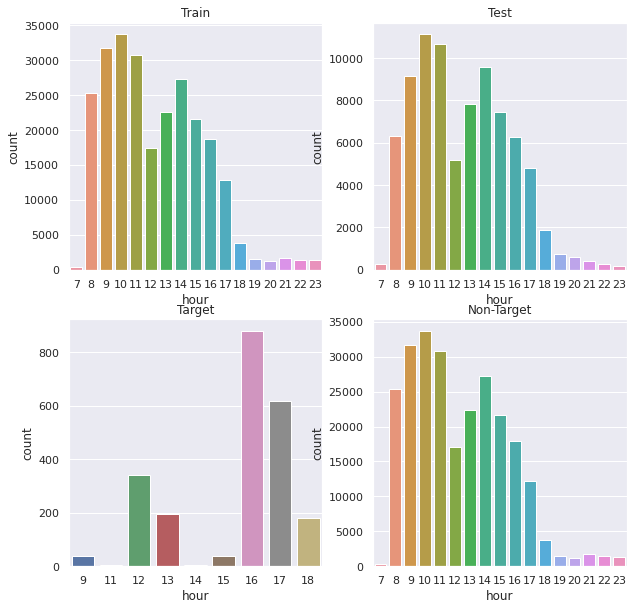

In [27]:
plot_feature(time_features_train, time_features_test, 'countplot', 'hour')

#### Круговые координаты на основе часа

In [28]:
time_features_train['sin_hour'] = df_train_times['time1'].apply(lambda ts: np.sin(2*np.pi*ts.hour/24))
time_features_train['cos_hour'] = df_train_times['time1'].apply(lambda ts: np.cos(2*np.pi*ts.hour/24))
time_features_test['sin_hour'] = df_test_times['time1'].apply(lambda ts: np.sin(2*np.pi*ts.hour/24))
time_features_test['cos_hour'] = df_test_times['time1'].apply(lambda ts: np.cos(2*np.pi*ts.hour/24))

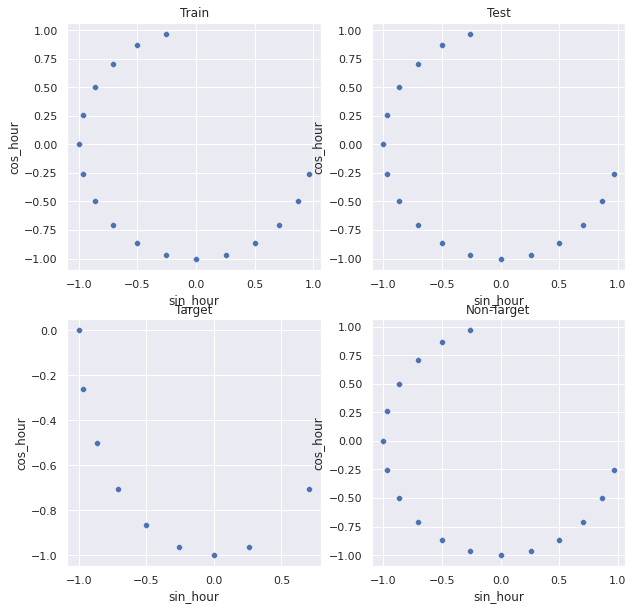

In [29]:
plot_feature(time_features_train, time_features_test, 'scatterplot', 'sin_hour', 'cos_hour')

#### Минуты

In [30]:
time_features_train['minute'] = df_train_times['time1'].apply(lambda ts: ts.minute)
time_features_test['minute'] = df_test_times['time1'].apply(lambda ts: ts.minute)

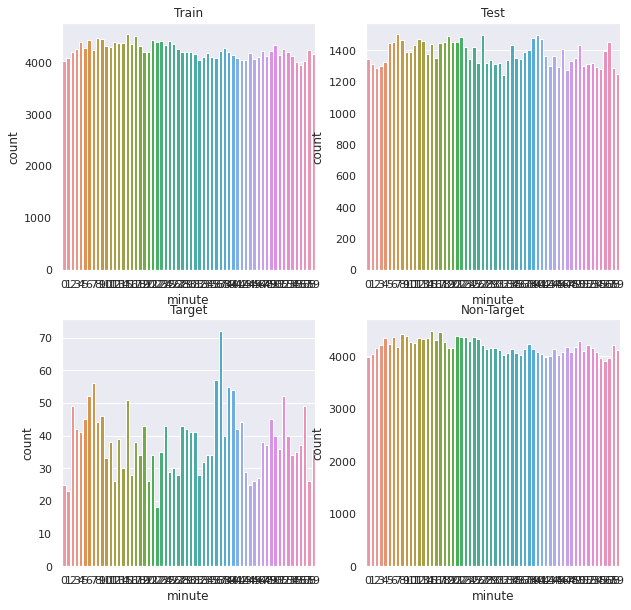

In [31]:
plot_feature(time_features_train, time_features_test, 'countplot', 'minute')

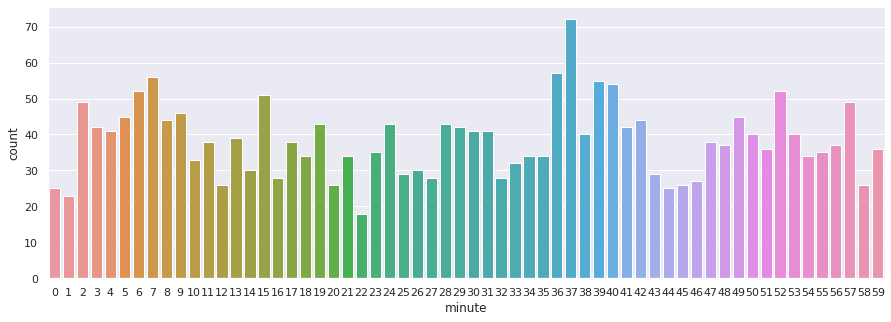

In [32]:
plt.figure(figsize=(15, 5))
sns.countplot(x=time_features_train[time_features_train.target == 1]['minute']);

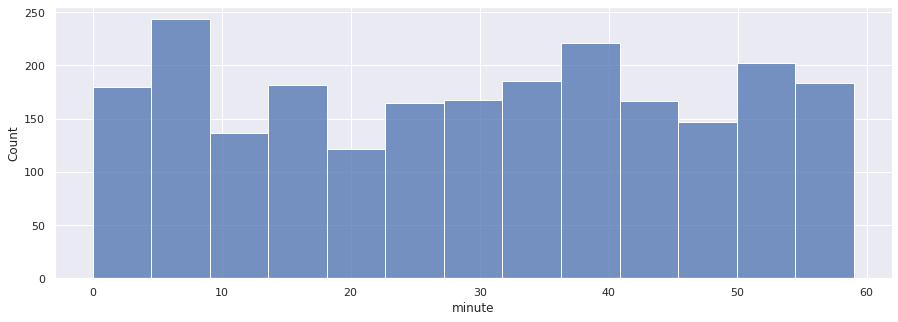

In [33]:
plt.figure(figsize=(15, 5))
sns.histplot(x=time_features_train[time_features_train.target == 1]['minute']);

#### Секунды

In [34]:
time_features_train['second'] = df_train_times['time1'].apply(lambda ts: ts.second)
time_features_test['second'] = df_test_times['time1'].apply(lambda ts: ts.second)

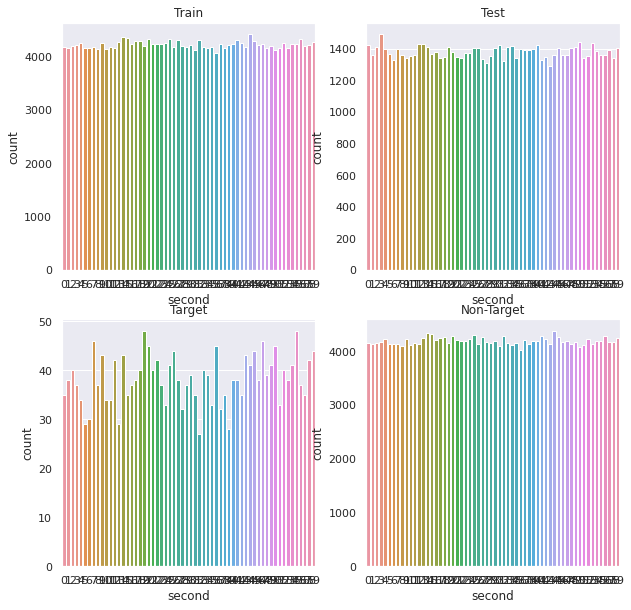

In [35]:
plot_feature(time_features_train, time_features_test, 'countplot', 'second')

#### Час+минуты
Точное распределение по времени суток

In [36]:
time_features_train['hour_minute'] = df_train_times['time1'].apply(lambda ts: (ts.hour * 60 + ts.minute))
time_features_test['hour_minute'] = df_test_times['time1'].apply(lambda ts: (ts.hour * 60 + ts.minute))

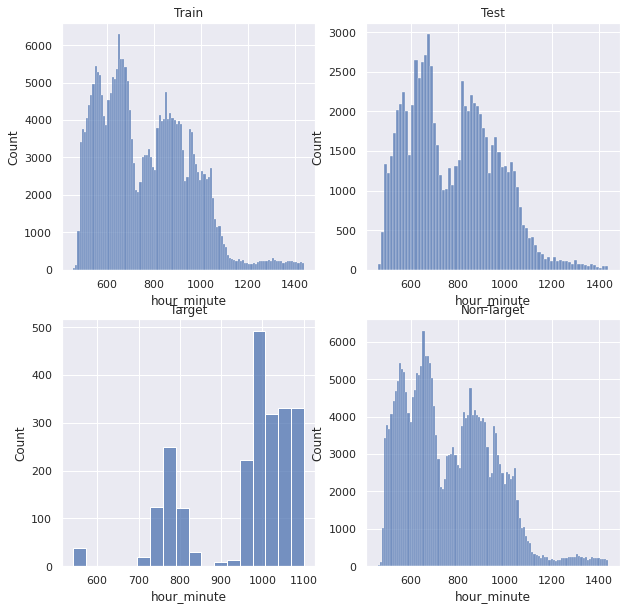

In [37]:
plot_feature(time_features_train, time_features_test, 'histplot', 'hour_minute')

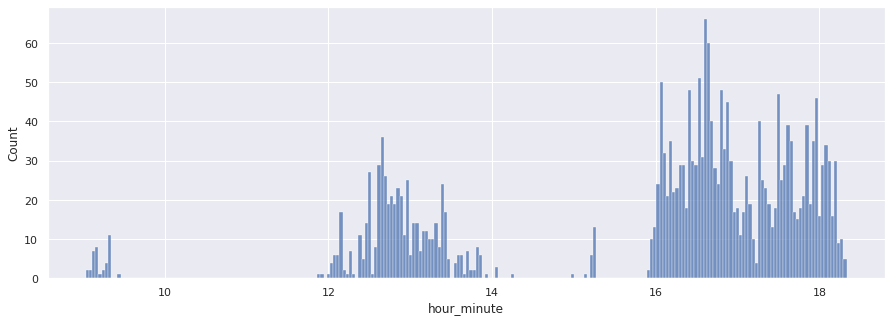

In [38]:
plt.figure(figsize=(15, 5))
sns.histplot(x=time_features_train[time_features_train.target == 1]['hour_minute']/60, bins=240);

#### Месяц

In [39]:
time_features_train['month'] = df_train_times['time1'].apply(lambda ts: ts.month)
time_features_test['month'] = df_test_times['time1'].apply(lambda ts: ts.month)

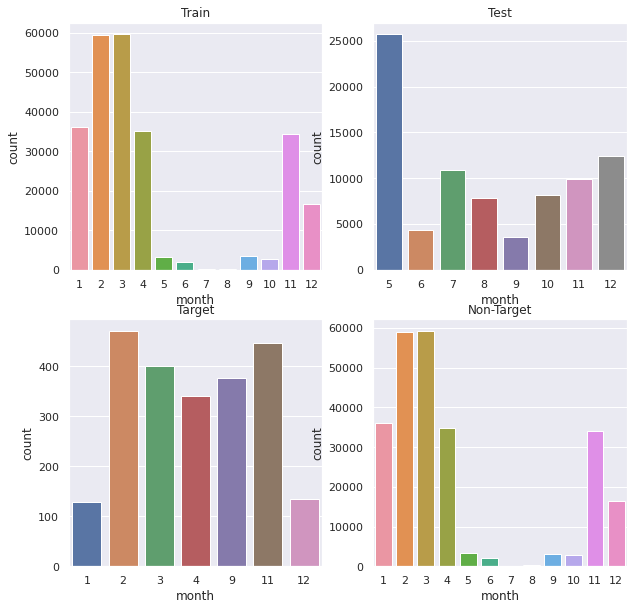

In [40]:
plot_feature(time_features_train, time_features_test, 'countplot', 'month')

#### Год

In [41]:
time_features_train['year'] = df_train_times['time1'].apply(lambda ts: ts.year)
time_features_test['year'] = df_test_times['time1'].apply(lambda ts: ts.year)

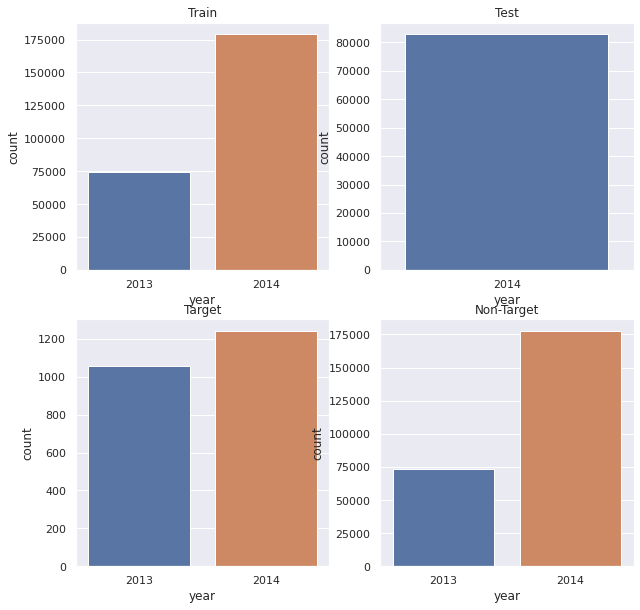

In [42]:
plot_feature(time_features_train, time_features_test, 'countplot', 'year')

#### Год+месяц

In [43]:
time_features_train['year_month'] = df_train_times['time1'].apply(lambda ts: ts.year + (ts.month - 1) / 12)
time_features_test['year_month'] = df_test_times['time1'].apply(lambda ts: ts.year + (ts.month - 1) / 12)

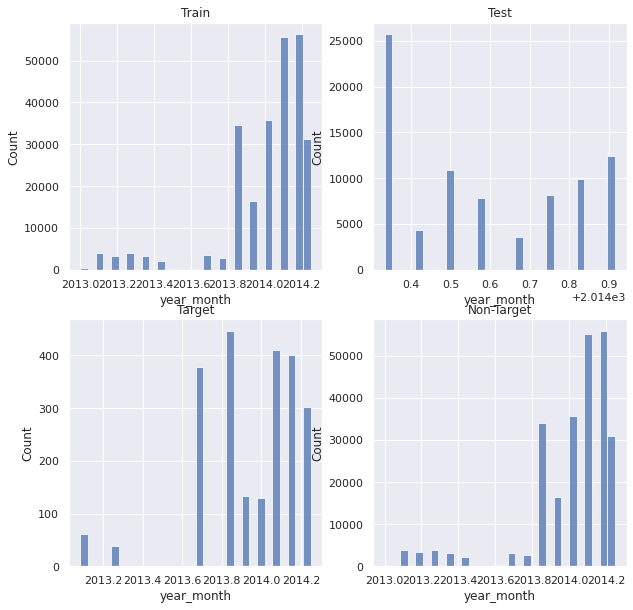

In [44]:
plot_feature(time_features_train, time_features_test, 'histplot', 'year_month', bins=30)

#### День недели

In [45]:
time_features_train['day'] = df_train_times['time1'].apply(lambda ts: ts.weekday())
time_features_test['day'] = df_test_times['time1'].apply(lambda ts: ts.weekday())

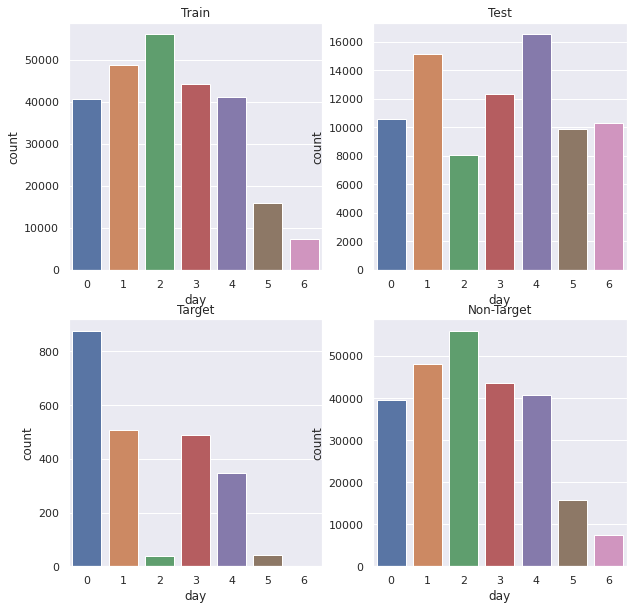

In [46]:
plot_feature(time_features_train, time_features_test, 'countplot', 'day')

#### Длина сессии

In [47]:
%%time
time_features_train['duration'] = df_train_times.apply(lambda row: (row.max() - row.min()).total_seconds(), axis=1)
time_features_test['duration'] = df_test_times.apply(lambda row: (row.max() - row.min()).total_seconds(), axis=1)

CPU times: user 51.6 s, sys: 85.2 ms, total: 51.7 s
Wall time: 51.7 s


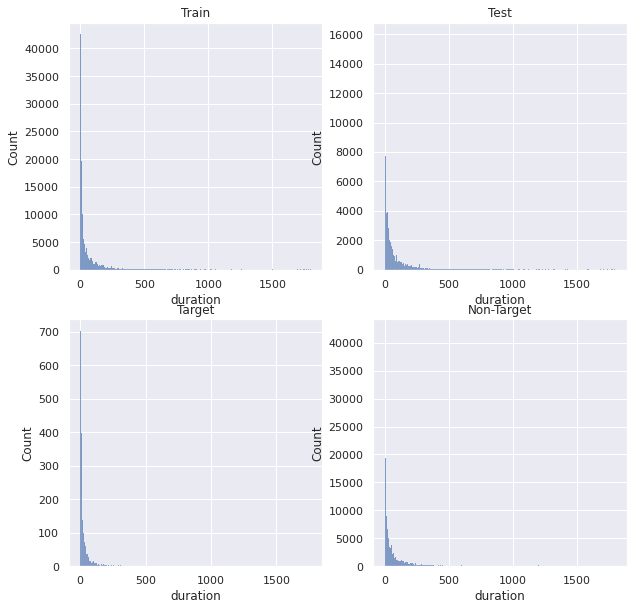

In [48]:
plot_feature(time_features_train, time_features_test, 'histplot', 'duration')

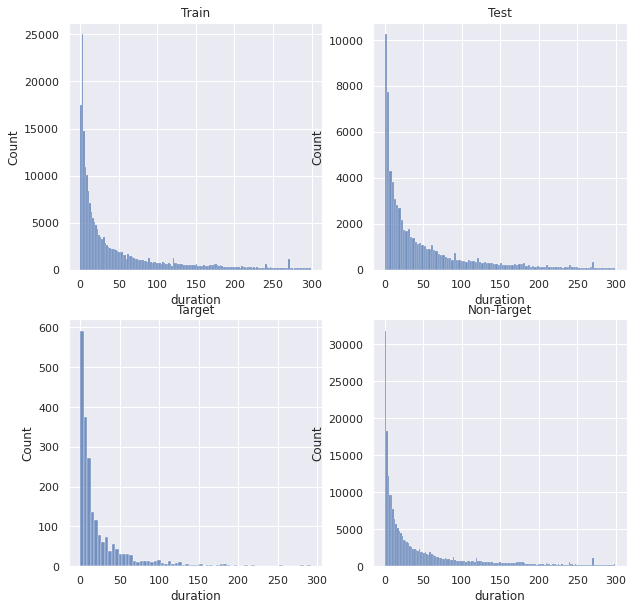

In [49]:
plot_feature(time_features_train[time_features_train.duration < 300], 
             time_features_test[time_features_test.duration < 300], 'histplot', 'duration')

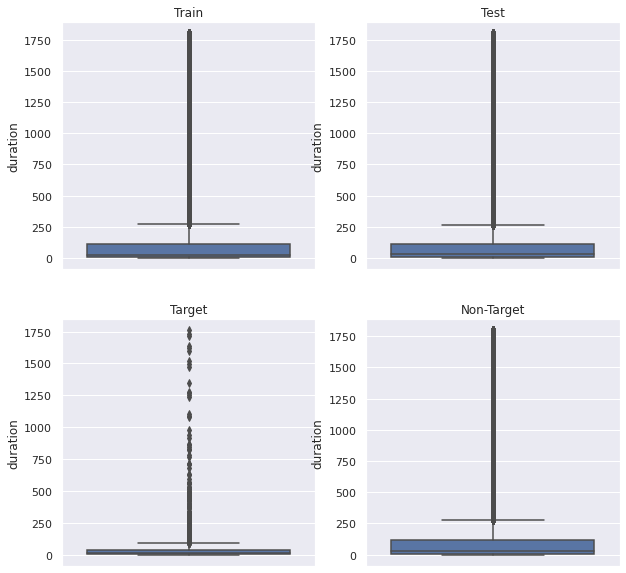

In [50]:
plot_feature(time_features_train, time_features_test, 'boxplot', 'duration')

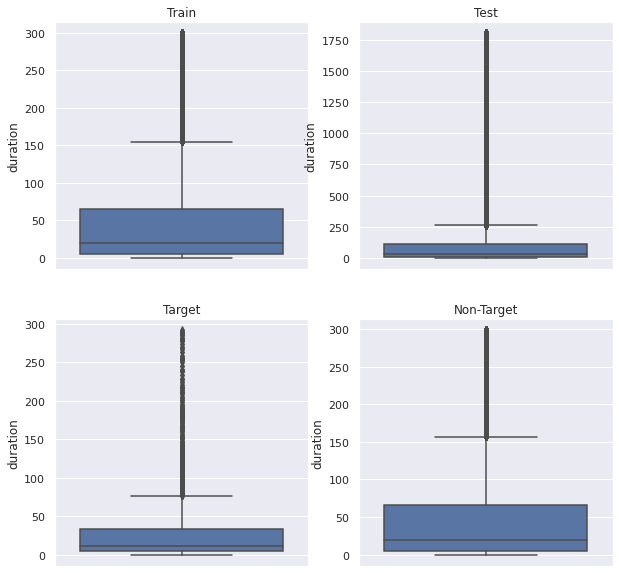

In [51]:
plot_feature(time_features_train[time_features_train.duration < 300], 
             time_features_test[time_features_train.duration < 300], 'boxplot', 'duration')

#### Time diffs

In [65]:
def get_time_diffs(session):
    time_length = session.shape[0] - 1 
    time_diff = [0]*time_length
#     not_na = pd.Series(session)[pd.notna]
    i = 0
    while i < time_length and pd.notnull(session[i+1]):
        time_diff[i] = (session[i+1] - session[i]) / np.timedelta64(1,'s') 
        i += 1
    return pd.Series(time_diff)

In [66]:
%%time
df_train_td = df_train_times.apply(lambda session: get_time_diffs(session), axis=1)
df_test_td = df_test_times.apply(lambda session: get_time_diffs(session), axis=1)

CPU times: user 3min 20s, sys: 769 ms, total: 3min 21s
Wall time: 3min 21s


In [68]:
time_diffs = [f'time_diff_{i}' for i in range(1, 10)]
df_train_td.columns = time_diffs
df_test_td.columns = time_diffs

In [70]:
time_features_train = pd.concat([time_features_train, df_train_td], axis=1, ignore_index=False)
time_features_test = pd.concat([time_features_test, df_test_td], axis=1, ignore_index=False)

### Сайты

In [90]:
df_train_sites = df_train[sites]
df_train_sites = df_train_sites.fillna(0).astype(int)
df_test_sites = df_test[sites]

site_features_train = pd.DataFrame()
site_features_test = pd.DataFrame()

site_features_train['target'] = df_train["target"].astype('int')

#### Число сайтов за сессию

In [91]:
%%time
site_features_train['n_sites'] = df_train[sites].apply(lambda session: session.count(), axis=1)
site_features_test['n_sites'] = df_test[sites].apply(lambda session: session.count(), axis=1)

CPU times: user 8.61 s, sys: 70 ms, total: 8.68 s
Wall time: 8.67 s


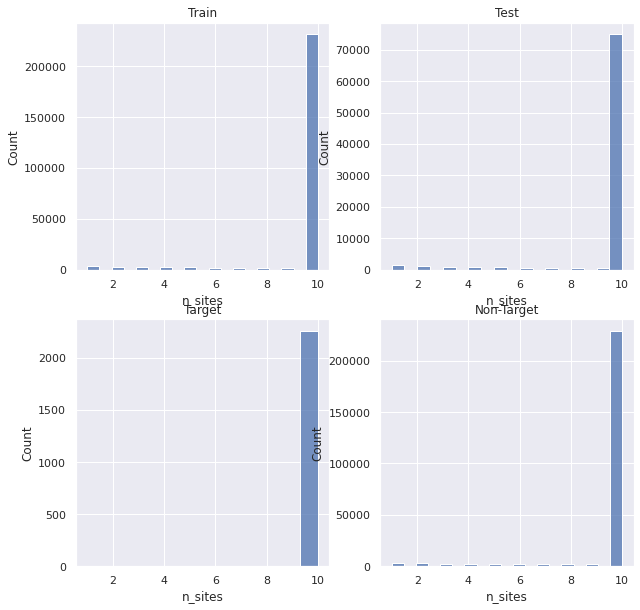

In [92]:
plot_feature(site_features_train, site_features_test, 'histplot', 'n_sites')

#### Топ-10 сайтов

In [125]:
site_counts = {}
for session in df_train_sites.values:
    for site in session:
        if site in site_counts:
            site_counts[site] += 1
        else:
            site_counts[site] = 1
site_counts.pop(0)

122730

In [128]:
top_n = [k for k, _ in sorted(site_counts.items(), key=lambda item: item[1], reverse=True)][:50]

In [129]:
for site_id in top_n:
    print(f'{id2site[site_id]}: {site_counts[site_id]}')

www.google.fr: 123776
www.google.com: 87619
annotathon.org: 77055
apis.google.com: 58258
www.facebook.com: 54094
www.bing.com: 46405
blast.ncbi.nlm.nih.gov: 43841
www.ncbi.nlm.nih.gov: 38194
clients1.google.com: 36085
mail.google.com: 35178
s.youtube.com: 31391
plus.google.com: 30616
safebrowsing-cache.google.com: 27812
accounts.google.com: 25275
twitter.com: 23726
platform.twitter.com: 23495
www.phylogeny.fr: 23026
s-static.ak.facebook.com: 22470
www.youtube.com: 20922
static.ak.facebook.com: 19683
login.live.com: 18130
i1.ytimg.com: 17270
docs.google.com: 16890
translate.google.fr: 15920
drive.google.com: 15879
clients1.google.fr: 14211
safebrowsing.clients.google.com: 13539
api.bing.com: 13534
ajax.googleapis.com: 13240
mts0.google.com: 11984
bits.wikimedia.org: 11812
fr.wikipedia.org: 10927
mts1.google.com: 10535
download.jboss.org: 10284
s.ytimg.com: 10105
api.twitter.com: 9367
h.live.com: 9225
clients6.google.com: 9168
connect.facebook.net: 9109
ts1.mm.bing.net: 8911
fr.openclass

In [130]:
site_counts_target = {}
for session in df_train_sites[y_train == 1].values:
    for site in session:
        if site in site_counts_target:
            site_counts_target[site] += 1
        else:
            site_counts_target[site] = 1
# site_counts_target.pop(0)

In [131]:
top_n_target = [k for k, _ in sorted(site_counts_target.items(), key=lambda item: item[1], reverse=True)][:50]

In [132]:
for site_id in top_n_target:
    print(f'{id2site[site_id]}: {site_counts_target[site_id]}')

i1.ytimg.com: 1382
s.youtube.com: 1354
www.youtube.com: 1307
www.facebook.com: 897
www.google.fr: 857
r4---sn-gxo5uxg-jqbe.googlevideo.com: 609
apis.google.com: 522
r1---sn-gxo5uxg-jqbe.googlevideo.com: 522
s.ytimg.com: 451
r2---sn-gxo5uxg-jqbe.googlevideo.com: 447
www.google.com: 437
s-static.ak.facebook.com: 381
r3---sn-gxo5uxg-jqbe.googlevideo.com: 371
twitter.com: 293
static.ak.facebook.com: 291
vk.com: 286
translate.google.fr: 274
platform.twitter.com: 272
yt3.ggpht.com: 236
mts0.google.com: 215
www.info-jeunes.net: 209
clients1.google.com: 206
www.audienceinsights.net: 204
unknown: 201
www.melty.fr: 188
gg.google.com: 159
plus.googleapis.com: 155
mts1.google.com: 153
api.bing.com: 151
youwatch.org: 150
www.dailymotion.com: 150
deliv.leboncoin.fr: 143
login.live.com: 129
static.leboncoin.fr: 126
khms0.google.fr: 125
khms1.google.fr: 124
wwwd.caf.fr: 123
accounts.google.com: 121
media.melty.fr: 121
www.leboncoin.fr: 110
connect.facebook.net: 109
clients1.google.fr: 106
h.live.com: 

In [95]:
%%time
site_features_train['has_top10'] = df_train_sites.apply(lambda session: session.isin(top10).any().astype('int'), axis=1)
site_features_test['has_top10'] = df_test_sites.apply(lambda session: session.isin(top10).any().astype('int'), axis=1)

CPU times: user 53 s, sys: 538 ms, total: 53.5 s
Wall time: 52.7 s


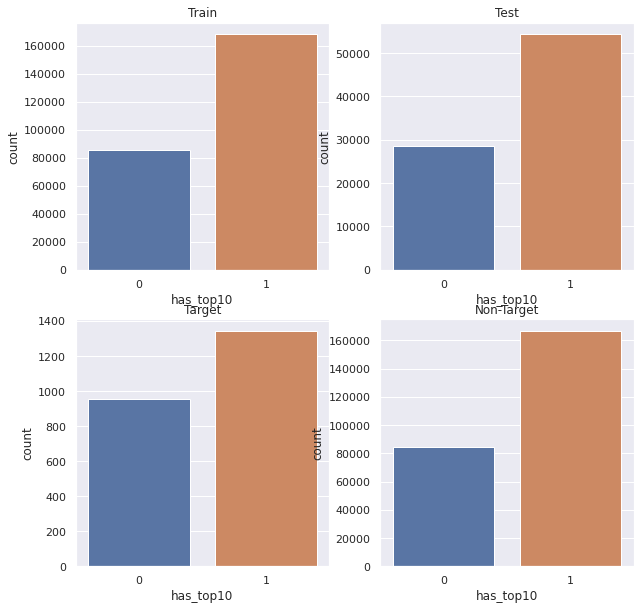

In [97]:
plot_feature(site_features_train, site_features_test, 'countplot', 'has_top10')

#### Число уникальных сайтов

In [106]:
%%time
site_features_train['n_unique'] = df_train_sites.apply(lambda session: session.nunique(), axis=1)
site_features_test['n_unique'] = df_test_sites.apply(lambda session: session.nunique(), axis=1)

CPU times: user 47.3 s, sys: 3.45 s, total: 50.7 s
Wall time: 47.5 s


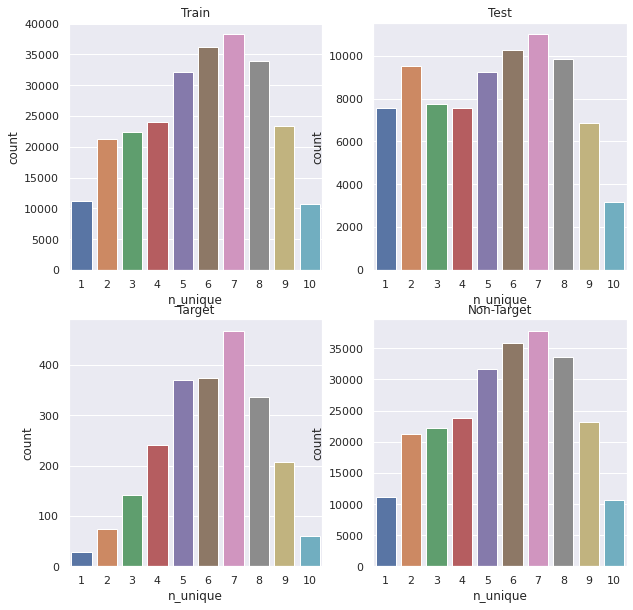

In [108]:
plot_feature(site_features_train, site_features_test, 'countplot', 'n_unique')

#### Абсолютно уникальные сайты - TBD

In [ ]:
# absolutely_unique_sites.update(df_train_sites.iloc[0])

In [ ]:
# a = set()
# b = set(df_train_sites.iloc[0])
# a, b

In [ ]:
# b = set(df_train_sites.iloc[2])
# b

In [ ]:
# a.symmetric_difference_update(b)
# a

In [ ]:
# a.update(b)
# a

In [ ]:
# a.difference_update(a)

In [ ]:
# absolutely_unique_sites, full_sites = set()
# for session in df_train_sites.values:
#     uniques = set(session)
#     uniques.difference_update(full_sites)
#     absolutely_unique_sites.update(uniques)

In [ ]:
# len(absolutely_unique_sites)

In [ ]:
# absolutely_unique_sites

In [ ]:
# site_counts[13122]

In [ ]:
# id2site[13122]

In [ ]:
# set_of_sites = set()
# for session in df_train_sites.values:
#     set_of_sites.update(session)
# len(set_of_sites)

In [ ]:
# set_of_sites_target = set()
# for session in df_train_sites[y_train == 1].values:
#     set_of_sites_target.update(session)
# len(set_of_sites_target)

In [ ]:
# len(set_of_sites_target.intersection(set_of_sites))

#### Домены

In [117]:
domain_counts = {}
for session in df_train_sites.values:
    for site_id in session:
        domain_name = id2site[site_id]
        domain = domain_name.split('.')[-1]
        if domain in domain_counts:
            domain_counts[domain] += 1
        else:
            domain_counts[domain] = 1

In [133]:
top_domains = [k for k, _ in sorted(domain_counts.items(), key=lambda item: item[1], reverse=True)][:50]

In [134]:
for domain in top_domains:
    print(f'{domain}: {domain_counts[domain]}')

com: 1499368
fr: 411545
org: 165500
net: 155393
unknown: 122730
gov: 86769
cn: 15340
uk: 11621
ru: 5878
io: 5567
de: 5303
edu: 4027
ca: 2986
ms: 2983
40: 2968
50: 2793
30: 2677
60: 2651
fi: 2254
tv: 1995
au: 1849
be: 1830
eu: 1565
info: 1307
pe: 1265
me: 1231
ch: 1205
ma: 1119
es: 968
us: 946
dk: 825
dz: 817
pro: 779
jp: 715
tt: 480
193: 437
it: 419
pl: 418
co: 406
fm: 397
nz: 332
biz: 323
li: 322
cc: 250
ro: 222
ws: 217
br: 196
nl: 163
118: 148
is: 147


In [135]:
domain_counts_t = {}
for session in df_train_sites[y_train == 1].values:
    for site_id in session:
        domain_name = id2site[site_id]
        domain = domain_name.split('.')[-1]
        if domain in domain_counts_t:
            domain_counts_t[domain] += 1
        else:
            domain_counts_t[domain] = 1

In [136]:
for domain in domain_counts_t:
    print(f'{domain}: {domain_counts_t[domain]}')

com: 16241
fr: 3689
net: 1464
50: 130
60: 116
40: 133
30: 117
tt: 61
org: 292
cc: 11
tv: 60
ru: 37
unknown: 201
info: 33
uk: 137
fi: 14
am: 8
it: 7
be: 10
ca: 52
es: 6
jp: 5
br: 3
de: 7
ch: 4
io: 58
me: 22
110: 5
biz: 1
se: 2
ms: 12
ws: 18
81: 2
li: 3
la: 6
za: 1
us: 2
